In [61]:
#  Imports
# ---------------------------------------------------------------------
import os  # For folder creation
import yfinance as yf
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle  # For saving/loading models


In [62]:
# Download historical GOLDBEES ETF price data
# ---------------------------------------------------------------------
def download_gold_prices(start_date: datetime, end_date: datetime) -> pd.DataFrame:
    # Download historical GOLDBEES ETF price data
    print("\nStep 1: Downloading gold price data (GOLDBEES.BO)...")
    gold = yf.download('GOLDBEES.BO', start=start_date, end=end_date, progress=False)
    print("Download complete.")
    #print(gold.head())

    if isinstance(gold.columns, pd.MultiIndex):
        gold.columns = gold.columns.get_level_values(0)

    gold = gold[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
    gold.columns.name = None  # Remove "Price" label from column index

    print("Current working directory:", os.getcwd())  
    # Ensure the 'Data' directory exists
    os.makedirs("Data", exist_ok=True)

    # Save raw data to CSV
    gold.to_csv("Data/GOLDBEES_ETF_price_data.csv")
    print("Saved raw gold price data to Data/GOLDBEES_ETF_price_data.csv")
    #print(gold.columns)
    print(gold.head())
    return gold

In [63]:
start = datetime(2010, 1, 1)
end = datetime(2026, 1, 1)
gold = download_gold_prices(start, end)


Step 1: Downloading gold price data (GOLDBEES.BO)...
Download complete.
Current working directory: d:\Python\04_Python_DA225o\zDL_Project_Gold_Price_03
Saved raw gold price data to Data/GOLDBEES_ETF_price_data.csv
                 Open       High      Low      Close   Volume
Date                                                         
2010-02-05  15.980000  16.011000  15.7385  15.765000  2836000
2010-02-08  16.031000  16.098000  15.9600  16.062500   445700
2010-02-09  16.065001  16.065001  15.9600  15.997200   669100
2010-02-10  16.090000  16.108999  16.0221  16.060900   335400
2010-02-11  16.099001  16.099001  16.0305  16.059299   385300


In [64]:
# Technical Indicator Calculation
# ---------------------------------------------------------------------

#RSI Calculation
# ---------------------------------------------------------------------
def calculate_rsi(prices: pd.Series, period: int = 14) -> pd.Series:
    # Relative Strength Index calculation
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


# Technical Indicator Calculation
# ---------------------------------------------------------------------
def add_technical_indicators(gold: pd.DataFrame) -> pd.DataFrame:
    # Technical indicators
    print("\nStep 2: Adding technical indicators...")

    gold['Returns'] = gold['Close'].pct_change()
    gold['MA_5'] = gold['Close'].rolling(window=5).mean()
    gold['MA_20'] = gold['Close'].rolling(window=20).mean()
    gold['MA_50'] = gold['Close'].rolling(window=50).mean()
    gold['Volatility'] = gold['Returns'].rolling(window=20).std()
    gold['RSI'] = calculate_rsi(gold['Close'])

    print("\nStep 3: Calculating Bollinger Bands...")
    rolling_std = gold['Close'].rolling(window=20).std()
    gold['BB_upper'] = gold['MA_20'] + (rolling_std * 2)
    gold['BB_lower'] = gold['MA_20'] - (rolling_std * 2)
    gold['BB_width'] = gold['BB_upper'] - gold['BB_lower']
    gold['BB_position'] = (gold['Close'] - gold['BB_lower']) / gold['BB_width']

    # MACD and Signal Line
    exp1 = gold['Close'].ewm(span=12, adjust=False).mean()
    exp2 = gold['Close'].ewm(span=26, adjust=False).mean()
    gold['MACD'] = exp1 - exp2
    gold['MACD_Signal'] = gold['MACD'].ewm(span=9, adjust=False).mean()
    gold['MACD_Hist'] = gold['MACD'] - gold['MACD_Signal']

    # Momentum (n-day price diff)
    gold['Momentum_10'] = gold['Close'] - gold['Close'].shift(10)

    # Rate of Change (ROC)
    gold['ROC_10'] = gold['Close'].pct_change(periods=10)


    # Drop NaNs and infinite values after all calculations
    gold.replace([np.inf, -np.inf], np.nan, inplace=True)
    gold.dropna(inplace=True)


    # Desired column order
    columns_order = [
        'Date', 'Open', 'High', 'Low', 'Close', 'Volume',
        'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility', 'RSI',
        'BB_upper', 'BB_lower', 'BB_width', 'BB_position',
        'MACD', 'MACD_Signal', 'MACD_Hist',
        'Momentum_10', 'ROC_10'
    ]

    # Reorder and handle missing columns
    existing_cols = [col for col in columns_order if col in gold.columns]
    gold = gold[existing_cols]

    print(f"\nAdded indicators to {len(gold)} rows.")

    # Save full DataFrame with indicators
    gold.to_csv("Data/GOLDBEES_ETF_price_data_technical_indicators.csv")
    print("Saved technical indicators to Data/GOLDBEES_ETF_price_data_technical_indicators.csv")

    return gold



In [65]:
gold = add_technical_indicators(gold)


Step 2: Adding technical indicators...

Step 3: Calculating Bollinger Bands...

Added indicators to 3741 rows.
Saved technical indicators to Data/GOLDBEES_ETF_price_data_technical_indicators.csv


In [66]:
#Add continuous sentiment Based on Price Trend with Labels
# ---------------------------------------------------------------------
def generate_sentiment_from_trend_with_labels(gold: pd.DataFrame, seed: int = 42) -> pd.DataFrame:
    """
    Generate numeric sentiment scores and sentiment labels based on price returns.

    Args:
        gold (pd.DataFrame): DataFrame with 'Close' column
        seed (int): Random seed for reproducibility

    Returns:
        pd.DataFrame: Updated DataFrame with 'Sentiment' and 'Sentiment_Label' columns
    """
    import random
    random.seed(seed)

    gold = gold.copy()
    gold['Returns'] = gold['Close'].pct_change()

    sentiment_scores = []
    sentiment_labels = []

    for ret in gold['Returns']:
        if pd.isna(ret):
            sentiment = 0.0
        elif ret > 0.01:
            sentiment = round(random.uniform(0.5, 1.0), 2)
        elif ret > 0.0:
            sentiment = round(random.uniform(0.1, 0.5), 2)
        elif ret > -0.01:
            sentiment = round(random.uniform(-0.5, -0.1), 2)
        else:
            sentiment = round(random.uniform(-1.0, -0.5), 2)

        # Assign label
        if sentiment > 0.1:
            label = 'positive'
        elif sentiment < -0.1:
            label = 'negative'
        else:
            label = 'neutral'

        sentiment_scores.append(sentiment)
        sentiment_labels.append(label)

    gold['Sentiment'] = sentiment_scores
    gold['Sentiment_Label'] = sentiment_labels

    # Save to CSV
    os.makedirs("Data", exist_ok=True)
    gold.to_csv("Data/GOLDBEES_ETF_price_data_technical_indicators_sentiment.csv")
    print("Sentiment columns added and saved to Data/GOLDBEES_ETF_price_data_technical_indicators_sentiment.csv")

    return gold

In [67]:
gold = generate_sentiment_from_trend_with_labels(gold)

Sentiment columns added and saved to Data/GOLDBEES_ETF_price_data_technical_indicators_sentiment.csv


In [68]:
# Predict next day's gold price using ARIMAX with technical indicators.
# Loads today's model if exists, otherwise retrains and saves a new model.
# ---------------------------------------------------------------------
import os
import pickle
from datetime import datetime
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

def predict_next_day_gold_price_arimax(df: pd.DataFrame, arima_order=(1, 1, 1)):
    """
    Predict next day's gold price using ARIMAX with technical indicators.
    Loads today's model if exists, otherwise retrains and saves a new model.

    Returns:
        tuple: (next_day_price, model_fit, predicted_pct_change)
    """
    # -------------------------------
    # Step 1: Setup
    # -------------------------------
    model_dir = "Model/Arimax"
    os.makedirs(model_dir, exist_ok=True)
    today_str = datetime.now().strftime("%Y-%m-%d")
    model_path = os.path.join(model_dir, f"arimax_{today_str}.pkl")

    # -------------------------------
    # Step 2: Define Exogenous Features
    # -------------------------------
    exog_cols = [
        'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',
        'RSI', 'BB_upper', 'BB_lower', 'BB_width',
        'BB_position', 'Sentiment',
        'MACD', 'MACD_Signal', 'MACD_Hist',
        'Momentum_10', 'ROC_10'
    ]

    for col in exog_cols:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    df = df[['Close'] + exog_cols].dropna()
    df = df.asfreq('B')
    df.ffill(inplace=True)

    y = df['Close']
    exog = df[exog_cols]

    # -------------------------------
    # Step 3: Check if today's model exists
    # -------------------------------
    if os.path.exists(model_path):
        print(f"📦 Loading existing ARIMAX model for today: {model_path}")
        with open(model_path, "rb") as f:
            model_fit = pickle.load(f)
    else:
        print("🧠 No model found for today. Retraining ARIMAX model...")

        # Clean old models
        for fname in os.listdir(model_dir):
            if fname.startswith("arimax_") and fname.endswith(".pkl"):
                os.remove(os.path.join(model_dir, fname))

        # Train new model
        model = SARIMAX(endog=y, exog=exog, order=arima_order,
                        enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False, method='powell')

        with open(model_path, "wb") as f:
            pickle.dump(model_fit, f)
        print(f"💾 Saved new ARIMAX model to: {model_path}")

    # -------------------------------
    # Step 4: Forecast Next Price
    # -------------------------------
    next_exog = exog.iloc[[-1]].values
    predicted_price = model_fit.forecast(steps=1, exog=next_exog).iloc[0]
    current_price = y.iloc[-1]
    next_day_pct_change = ((predicted_price - current_price) / current_price) * 100
    next_day = y.index[-1] + pd.tseries.offsets.BDay(1)

    print("\n📊 Prediction for next day")
    print(f"Current price: ₹{current_price:.2f}")
    print(f"Predicted % change: {next_day_pct_change:.2f}%")
    print(f"Predicted next-day price: ₹{predicted_price:.2f}")

    return predicted_price, model_fit, next_day_pct_change


In [69]:
predicted_price, model_fit, next_day_pct_change = predict_next_day_gold_price_arimax(gold)

📦 Loading existing ARIMAX model for today: Model/Arimax\arimax_2025-06-19.pkl

📊 Prediction for next day
Current price: ₹82.77
Predicted % change: -0.31%
Predicted next-day price: ₹82.52


In [70]:
# Predict next day's gold price using XGBoost with technical indicators.
# Loads today's model if exists, otherwise retrains and saves a new model.
# ---------------------------------------------------------------------
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler


def predict_next_day_gold_price_xgboost(gold: pd.DataFrame, test_size: float = 0.2, random_state: int = 42):
    model_dir = "Model/XGBoost"
    os.makedirs(model_dir, exist_ok=True)
    today_str = datetime.now().strftime("%Y-%m-%d")
    model_path = os.path.join(model_dir, f"xgboost_{today_str}.pkl")

    # Remove old models
    for fname in os.listdir(model_dir):
        if fname.startswith("xgboost_") and fname.endswith(".pkl") and fname != f"xgboost_{today_str}.pkl":
            os.remove(os.path.join(model_dir, fname))

    feature_cols = [
        'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',
        'RSI', 'BB_upper', 'BB_lower', 'BB_width',
        'BB_position', 'Sentiment',
        'MACD', 'MACD_Signal', 'MACD_Hist',
        'Momentum_10', 'ROC_10'
    ]

    gold_clean = gold[['Close'] + feature_cols].copy().dropna()
    gold_clean['Close_pct_change_1'] = gold_clean['Close'].pct_change(1)
    gold_clean['Close_pct_change_2'] = gold_clean['Close'].pct_change(2)
    gold_clean['Close_pct_change_3'] = gold_clean['Close'].pct_change(3)
    gold_clean['Close_rolling_std_5'] = gold_clean['Close'].rolling(5).std()
    gold_clean['Close_rolling_std_10'] = gold_clean['Close'].rolling(10).std()
    gold_clean['Close_vs_MA5'] = (gold_clean['Close'] - gold_clean['MA_5']) / gold_clean['MA_5']
    gold_clean['Close_vs_MA20'] = (gold_clean['Close'] - gold_clean['MA_20']) / gold_clean['MA_20']
    feature_cols_extended = feature_cols + [
        'Close_pct_change_1', 'Close_pct_change_2', 'Close_pct_change_3',
        'Close_rolling_std_5', 'Close_rolling_std_10',
        'Close_vs_MA5', 'Close_vs_MA20']
    gold_clean = gold_clean.dropna()
    gold_clean['Target_pct_change'] = gold_clean['Close'].pct_change().shift(-1)
    gold_clean['Target_price'] = gold_clean['Close'].shift(-1)
    gold_clean = gold_clean.dropna()
    gold_clean = gold_clean[
        (np.isfinite(gold_clean['Target_pct_change'])) &
        (np.abs(gold_clean['Target_pct_change']) < 1.0)
    ]

    if os.path.exists(model_path):
        print(f"Loading XGBoost model from {model_path}")
        with open(model_path, 'rb') as f:
            model = pickle.load(f)
    else:
        X = gold_clean[feature_cols_extended]
        y_pct = gold_clean['Target_pct_change']

        split_idx = int(len(X) * (1 - test_size))
        X_train, y_pct_train = X.iloc[:split_idx], y_pct.iloc[:split_idx]

        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)

        model = xgb.XGBRegressor(
            n_estimators=400,
            max_depth=10,
            learning_rate=0.008,
            min_child_weight=1,
            subsample=0.95,
            colsample_bytree=0.9,
            reg_alpha=0.001,
            reg_lambda=0.01,
            gamma=0,
            random_state=random_state,
            objective='reg:squarederror',
            tree_method='hist')

        print("Training new XGBoost model...")
        model.fit(X_train_scaled, y_pct_train)

        with open(model_path, 'wb') as f:
            pickle.dump(model, f)
        print(f"Saved model to {model_path}")

    # Predict next day
    latest_features = gold_clean[feature_cols_extended].iloc[[-1]]
    latest_price = gold_clean['Close'].iloc[-1]
    scaler = RobustScaler().fit(gold_clean[feature_cols_extended])
    latest_scaled = scaler.transform(latest_features)
    next_day_pct_change = model.predict(latest_scaled)[0]
    next_day_price = latest_price * (1 + next_day_pct_change)

    print(f"\nPrediction for next day")
    print(f"Current price: ₹{latest_price:.2f}")
    print(f"Predicted % change: {next_day_pct_change*100:.2f}%")
    print(f"Predicted next-day price: ₹{next_day_price:.2f}")

    return next_day_price, model, next_day_pct_change


In [71]:
next_day_price, model, next_day_pct_change = predict_next_day_gold_price_xgboost(gold)

Loading XGBoost model from Model/XGBoost\xgboost_2025-06-19.pkl

Prediction for next day
Current price: ₹82.80
Predicted % change: 0.22%
Predicted next-day price: ₹82.98


In [72]:
# Predict next day's gold price using RandomForest with technical indicators.
# Loads today's model if exists, otherwise retrains and saves a new model.
# ---------------------------------------------------------------------
import os
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler


def predict_next_day_gold_price_rf(gold: pd.DataFrame, test_size: float = 0.2, random_state: int = 42):
    """
    Predict next day's gold price using Random Forest with enhanced features.
    Saves model daily and loads if already exists. Returns price, model, and percentage change.
    """
    model_dir = "Model/RandomForest"
    os.makedirs(model_dir, exist_ok=True)
    today_str = datetime.now().strftime("%Y-%m-%d")
    model_path = os.path.join(model_dir, f"random_forest_{today_str}.pkl")

    # Clean old models
    for fname in os.listdir(model_dir):
        if fname.startswith("random_forest_") and fname.endswith(".pkl") and fname != f"random_forest_{today_str}.pkl":
            os.remove(os.path.join(model_dir, fname))

    # Feature Engineering
    feature_cols = [
        'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',
        'RSI', 'BB_upper', 'BB_lower', 'BB_width',
        'BB_position', 'Sentiment'
    ]

    gold_clean = gold[['Close'] + feature_cols].copy()
    gold_clean = gold_clean.dropna()
    gold_clean['Close_pct_change_1'] = gold_clean['Close'].pct_change(1)
    gold_clean['Close_pct_change_2'] = gold_clean['Close'].pct_change(2)
    gold_clean['Close_pct_change_3'] = gold_clean['Close'].pct_change(3)
    gold_clean['Close_rolling_std_5'] = gold_clean['Close'].rolling(5).std()
    gold_clean['Close_rolling_std_10'] = gold_clean['Close'].rolling(10).std()
    gold_clean['Close_vs_MA5'] = (gold_clean['Close'] - gold_clean['MA_5']) / gold_clean['MA_5']
    gold_clean['Close_vs_MA20'] = (gold_clean['Close'] - gold_clean['MA_20']) / gold_clean['MA_20']
    gold_clean['Price_momentum_3'] = gold_clean['Close'] / gold_clean['Close'].shift(3) - 1
    gold_clean['Price_momentum_5'] = gold_clean['Close'] / gold_clean['Close'].shift(5) - 1

    feature_cols_extended = feature_cols + [
        'Close_pct_change_1', 'Close_pct_change_2', 'Close_pct_change_3',
        'Close_rolling_std_5', 'Close_rolling_std_10',
        'Close_vs_MA5', 'Close_vs_MA20',
        'Price_momentum_3', 'Price_momentum_5']

    gold_clean.dropna(inplace=True)
    gold_clean['Target_pct_change'] = gold_clean['Close'].pct_change().shift(-1)
    gold_clean['Target_price'] = gold_clean['Close'].shift(-1)
    gold_clean.dropna(inplace=True)
    gold_clean = gold_clean[(np.abs(gold_clean['Target_pct_change']) < 1.0)]

    if os.path.exists(model_path):
        print(f"📦 Loading existing Random Forest model for today: {model_path}")
        with open(model_path, "rb") as f:
            model = pickle.load(f)
    else:
        print("🧠 No model found for today. Training Random Forest model...")
        X = gold_clean[feature_cols_extended]
        y_pct = gold_clean['Target_pct_change']
        scaler = RobustScaler()
        X_scaled = scaler.fit_transform(X)
        model = RandomForestRegressor(
            n_estimators=200, max_depth=15, min_samples_split=5, min_samples_leaf=2,
            max_features='sqrt', bootstrap=True, random_state=random_state, n_jobs=-1)
        model.fit(X_scaled, y_pct)
        with open(model_path, "wb") as f:
            pickle.dump(model, f)
        print(f"💾 Saved model to {model_path}")

    # Predict next day
    latest_features = gold_clean[feature_cols_extended].iloc[[-1]]
    latest_price = gold_clean['Close'].iloc[-1]
    scaler = RobustScaler().fit(gold_clean[feature_cols_extended])
    latest_scaled = scaler.transform(latest_features)
    next_day_pct_change = model.predict(latest_scaled)[0]
    next_day_price = latest_price * (1 + next_day_pct_change)

    print("\n📊 Random Forest Prediction")
    print(f"Current price: ₹{latest_price:.2f}")
    print(f"Predicted % change: {next_day_pct_change * 100:.2f}%")
    print(f"Predicted next-day price: ₹{next_day_price:.2f}")

    return next_day_price, model, next_day_pct_change


In [73]:
next_day_price, model, next_day_pct_change = predict_next_day_gold_price_rf(gold)

📦 Loading existing Random Forest model for today: Model/RandomForest\random_forest_2025-06-19.pkl

📊 Random Forest Prediction
Current price: ₹82.80
Predicted % change: -0.02%
Predicted next-day price: ₹82.78


In [74]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import pickle

class GoldPriceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])


def predict_next_day_gold_price_lstm(gold: pd.DataFrame, sequence_length=10, epochs=50, batch_size=16, lr=0.001):
    model_dir = "Model/LSTM"
    os.makedirs(model_dir, exist_ok=True)
    today_str = datetime.now().strftime("%Y-%m-%d")
    model_path = os.path.join(model_dir, f"lstm_{today_str}.pt")

    # -------------------------------
    # Step 1: Feature Setup
    # -------------------------------
    feature_cols = [
        'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',
        'RSI', 'BB_upper', 'BB_lower', 'BB_width',
        'BB_position', 'Sentiment'
    ]

    gold = gold[['Close'] + feature_cols].dropna()
    gold = gold.asfreq('B')
    gold.ffill(inplace=True)
    gold['Target'] = gold['Close'].shift(-1)
    gold.dropna(inplace=True)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(gold[feature_cols])
    y_scaled = scaler.fit_transform(gold[['Target']])

    X_seq, y_seq = [], []
    for i in range(len(X_scaled) - sequence_length):
        X_seq.append(X_scaled[i:i + sequence_length])
        y_seq.append(y_scaled[i + sequence_length])

    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)

    # -------------------------------
    # Step 2: Load or Train Model
    # -------------------------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMModel(input_size=X_seq.shape[2]).to(device)

    if os.path.exists(model_path):
        print(f"📦 Loading LSTM model from {model_path}")
        model.load_state_dict(torch.load(model_path))
        model.eval()
    else:
        print("🧠 No model found for today. Retraining LSTM model...")

        # Delete old models
        for f in os.listdir(model_dir):
            if f.startswith("lstm_") and f.endswith(".pt"):
                os.remove(os.path.join(model_dir, f))

        train_ds = GoldPriceDataset(X_seq, y_seq)
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        model.train()
        for epoch in range(epochs):
            for xb, yb in train_dl:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                output = model(xb).squeeze()
                loss = criterion(output, yb.squeeze())
                loss.backward()
                optimizer.step()
            if epoch % 10 == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch} - Loss: {loss.item():.6f}")

        torch.save(model.state_dict(), model_path)
        print(f"💾 Saved new LSTM model to: {model_path}")

    # -------------------------------
    # Step 3: Forecast
    # -------------------------------
    model.eval()
    last_seq = torch.tensor(X_scaled[-sequence_length:], dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        next_pred = model(last_seq).cpu().numpy()

    predicted_price = scaler.inverse_transform(
        np.concatenate([np.zeros((1, len(feature_cols))), next_pred], axis=1)
    )[:, -1][0]

    current_price = gold['Close'].iloc[-1]
    next_day_pct_change = (predicted_price - current_price) / current_price

    print("\n📊 LSTM Prediction Summary")
    print(f"Current price: ₹{current_price:.2f}")
    print(f"Predicted % change: {next_day_pct_change*100:.2f}%")
    print(f"Predicted next-day price: ₹{predicted_price:.2f}")

    return predicted_price, model, next_day_pct_change

In [75]:
predicted_price, model, next_day_pct_change = predict_next_day_gold_price_lstm(gold)

📦 Loading LSTM model from Model/LSTM\lstm_2025-06-19.pt

📊 LSTM Prediction Summary
Current price: ₹82.80
Predicted % change: 1.16%
Predicted next-day price: ₹83.76


In [76]:
def compare_model_predictions_old(actual_price: float,
                              arimax_price: float,
                              xgb_price: float,
                              rf_price: float,
                              lstm_price: float) -> None:
    """
    Compare predicted next-day prices from different models.

    Args:
        actual_price (float): Last actual known price
        arimax_price (float): ARIMAX predicted price
        xgb_price (float): XGBoost predicted price
        rf_price (float): Random Forest predicted price
        lstm_price (float): LSTM predicted price
    """
    import matplotlib.pyplot as plt
    import pandas as pd

    data = {
        'Model': ['Actual (Today)', 'ARIMAX', 'XGBoost', 'Random Forest', 'LSTM'],
        'Price': [actual_price, arimax_price, xgb_price, rf_price, lstm_price]
    }
    gold = pd.DataFrame(data)

    plt.figure(figsize=(10, 6))
    bars = plt.bar(gold['Model'], gold['Price'], color=['gray', 'orange', 'green', 'blue', 'purple'])

    # Annotate price on top
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.2, f"₹{yval:.2f}", ha='center', va='bottom')

    plt.title("📊 Next-Day Gold Price Predictions from Different Models")
    plt.ylabel("Price (INR)")
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()


In [77]:
def compare_model_predictions(actual_price: float,
                              arimax_price: float,
                              xgb_price: float,
                              rf_price: float,
                              lstm_price: float) -> None:
    import matplotlib.pyplot as plt
    import pandas as pd

    data = {
        'Model': ['ARIMAX', 'XGBoost', 'Random Forest', 'LSTM'],
        'Price': [arimax_price, xgb_price, rf_price, lstm_price]
    }
    df = pd.DataFrame(data)
    df['% Change'] = 100 * (df['Price'] - actual_price) / actual_price

    plt.figure(figsize=(10, 6))
    bars = plt.bar(df['Model'], df['Price'], color=['orange', 'green', 'blue', 'purple'])

    # Annotate price and % change with vertical padding
    for idx, bar in enumerate(bars):
        yval = bar.get_height()
        pct = df['% Change'].iloc[idx]
        text = f"₹{yval:.2f} ({pct:+.2f}%)"
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.9,  # <<-- increased from 0.3 to 1.0
                 text, ha='center', va='bottom', fontsize=10)

    plt.axhline(actual_price, color='gray', linestyle='--', linewidth=1.2, label=f"Actual ₹{actual_price:.2f}")
    plt.title("📊 Next-Day Gold Price Predictions vs Actual", fontsize=14)
    plt.ylabel("Price (INR)")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()



Step 1: Downloading gold price data (GOLDBEES.BO)...
Download complete.
Current working directory: d:\Python\04_Python_DA225o\zDL_Project_Gold_Price_03
Saved raw gold price data to Data/GOLDBEES_ETF_price_data.csv
                 Open       High      Low      Close   Volume
Date                                                         
2010-02-05  15.980000  16.011000  15.7385  15.765000  2836000
2010-02-08  16.031000  16.098000  15.9600  16.062500   445700
2010-02-09  16.065001  16.065001  15.9600  15.997200   669100
2010-02-10  16.090000  16.108999  16.0221  16.060900   335400
2010-02-11  16.099001  16.099001  16.0305  16.059299   385300

Step 2: Adding technical indicators...

Step 3: Calculating Bollinger Bands...

Added indicators to 3741 rows.
Saved technical indicators to Data/GOLDBEES_ETF_price_data_technical_indicators.csv
Sentiment columns added and saved to Data/GOLDBEES_ETF_price_data_technical_indicators_sentiment.csv
📦 Loading existing ARIMAX model for today: Model/Arima

C:\Users\BrintaJaison\AppData\Local\Temp\ipykernel_30748\3641966337.py:32: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\Python\04_Python_DA225o\python_env4\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


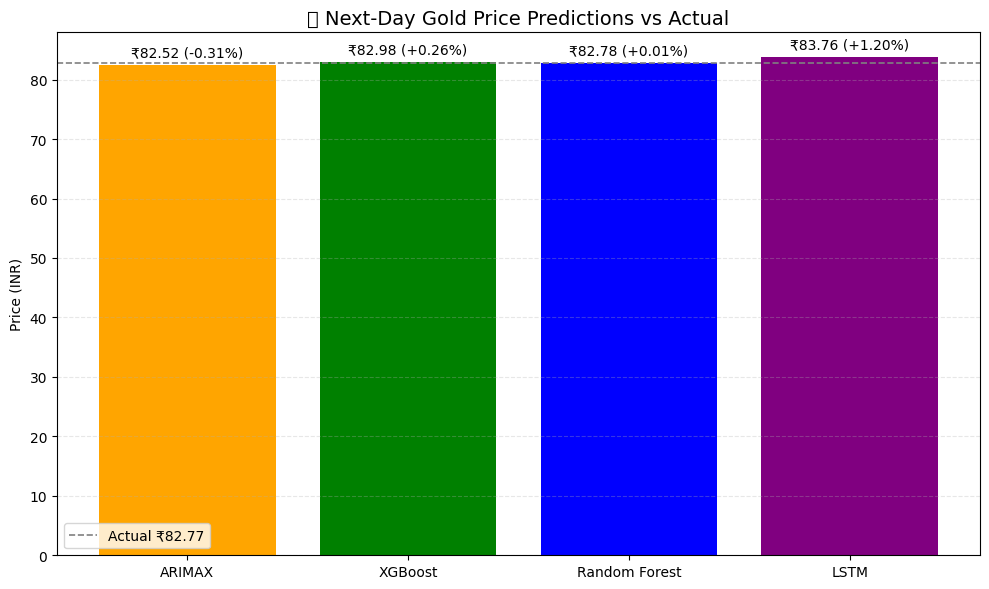

In [78]:
# Main function : Collect and process GOLDBEES (Indian Gold ETF) data with technical indicators
# ---------------------------------------------------------------------    
if __name__ == "__main__":
    start = datetime(2010, 1, 1)
    end = datetime(2026, 1, 1)

    # Step 1: Download and save raw price data
    gold = download_gold_prices(start, end)

        # Step 2: Add and save indicators
    if not gold.empty:
        gold = add_technical_indicators(gold)


    # Step 3: Add sentiment based on price trend
    if not gold.empty:
        # Uncomment one of the following lines to choose the sentiment generation method
        #gold = add_dummy_sentiment(gold)
        #gold = generate_sentiment_from_trend_wo_labels(gold)
        gold = generate_sentiment_from_trend_with_labels(gold)


    # Step 4: Predict next day's gold price using ARIMAX
    if not gold.empty:
        # Predict next day's price using ARIMAX with all indicators
        predicted_price_arimax, model_fit, next_day_pct_change = predict_next_day_gold_price_arimax(gold)


    # Step 5: Predict next day's price using XGBoost
    if not gold.empty:
        predicted_price_xgboost, model_fit, next_day_pct_change = predict_next_day_gold_price_xgboost(gold)

    # Step 7: Predict next day's price using Random Forest
    if not gold.empty:
        predicted_price_rf, model_fit, next_day_pct_change = predict_next_day_gold_price_rf(gold)

    # Step 8: Predict next day's price using LSTM
    if not gold.empty:
        predicted_price_lstm, model_fit, next_day_pct_change = predict_next_day_gold_price_lstm(gold)

    
    # Step 9: Compare all model predictions
    # Ensure we have all predictions before comparing
    if not gold.empty:
        actual_close_price = gold['Close'].dropna().iloc[-1]
        compare_model_predictions(
            actual_price=actual_close_price,
            arimax_price=predicted_price_arimax,
            xgb_price=predicted_price_xgboost,
            rf_price=predicted_price_rf,
            lstm_price=predicted_price_lstm
            )